In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anim
from IPython.display import HTML

In [36]:
def kinematics(lengths, angles, omegas, alphas, config):
        vectors = {'G': 0}
        vectors['G'] = lengths['G'] * np.exp(angles['G'] * 1j)
        vectors['1'] = lengths['1'] * np.exp(angles['1'] * 1j)
        # Using the coordinate @ end of L1 to find the B & C Angles

        C = vectors['G'] + vectors['1']

        unit_i = -1 * C/ np.abs(C)
        unit_j = unit_i * 1j

        # Finding the unknown angles

        Ax = (lengths['2']**2 + np.abs(C)**2 - lengths['3']**2) / (2 * np.abs(C))
        Bx = np.abs(C) - Ax

        Ay = np.sqrt(lengths['2']**2 - Ax**2)
        By = np.sqrt(lengths['3']**2 - Bx**2)
        if config:
                By = By * -1
        else:
                Ay = Ay * -1

        vectors['2'] = unit_i * Ax + unit_j * Ay
        vectors['3'] = unit_i * Bx + unit_j * By

        angles['2'] = np.angle(vectors['2'])
        angles['3'] = np.angle(vectors['3'])

        staticLengths = np.array( [[np.imag(vectors['2']), np.imag(vectors['3'])],
                            [np.real(vectors['2']), np.real(vectors['3'])]])
        vel = np.array([-1 * np.imag(vectors['1']), -1*np.real(vectors['1'])]) * omegas['1']

        omegas['2'], omegas['3'] = np.linalg.solve(staticLengths, vel)

        staticLengthsCross = np.array( 
        [[np.imag(vectors['1'] * 1j), np.imag(vectors['2']*1j), np.imag(vectors['3']*1j)],
        [np.real(vectors['1'] * 1j), np.real(vectors['2']*1j), np.real(vectors['3']*1j)]]
        )
        sqvel = np.array([omegas['1']**2, omegas['2']**2, omegas['3']**2])
        acc = np.array([np.imag(vectors['1']), np.real(vectors['1'])]) * alphas['1']

        #rhs = -1 * np.dot(staticLengthsCross,sqvel) - acc
        alphas['2'], alphas['3'] = np.linalg.solve(staticLengths, 
                                                -1 * np.dot(staticLengthsCross,sqvel).reshape((2,1)) - acc)
        
        return(vectors, omegas, alphas)

# Pitch Link

Running for pitch link

Desired output Angles:

In [37]:
ankle_pitch = [-50, +30]

Inputs:

In [38]:
ground_x = 200
ground_y = 60
ground_ang = float(np.angle(ground_x + ground_y*1j))

lengths = {'G': float(np.abs(ground_x + ground_y*1j)), # Ground
           '1': 120, # Drive Link
           '2': 0, # Connector Link
           '3': 150, # Output Link
           }
lengths['2'] = float(np.abs(ground_x + (lengths['3'] - lengths['1'])*1j))

angles = {'G': 180 * np.pi/180, # Required to be 180 to solve in current method. Map from and back to if you want other angles
          '1': np.pi/2 + ground_ang}
omegas = {'G':0,
        '1': 2} # Rad/s
alphas = {'G':0,
          '1':0} # Rad/s/s
config = True

lim = [angles['1'] + i * np.pi/180 for i in [-68, 40]]


resolution = 360

Initializations

In [39]:
kin = {
    'G': np.zeros(resolution,dtype=complex),
    'link1': np.zeros(resolution,dtype=complex),
    'omega1': np.zeros(resolution, dtype=float),
    'alpha1': np.zeros(resolution, dtype=float),
    'link2': np.zeros(resolution,dtype=complex),
    'omega2': np.zeros(resolution, dtype=float),
    'alpha2': np.zeros(resolution, dtype=float),
    'link3': np.zeros(resolution,dtype=complex),
    'omega3': np.zeros(resolution, dtype=float),
    'alpha3': np.zeros(resolution, dtype=float)
}

angs = np.linspace(lim[0], lim[1], resolution)

for i in range(len(angs)):
    angles['1'] = angs[i]
    kin_vals = kinematics(lengths, angles, omegas, alphas, config)    
    
    kin['G'][i] = kin_vals[0]['G']

    kin['link1'][i] = kin_vals[0]['1']
    kin['omega1'][i] = kin_vals[1]['1']
    kin['alpha1'][i] = kin_vals[2]['1']

    kin['link2'][i] = kin_vals[0]['2']
    kin['omega2'][i] = kin_vals[1]['2']
    kin['alpha2'][i] = kin_vals[2]['2'][0]

    kin['link3'][i] = kin_vals[0]['3']
    kin['omega3'][i] = kin_vals[1]['3']
    kin['alpha3'][i] = kin_vals[2]['3'][0]

Analysis:

_Note: Currently only set up to solve 'forward', requires manual iteration to approach desired output travel angles_

In [40]:
output_angles = [np.angle(-1 * a) - ground_ang for a in kin['link3']]
input_angles = [np.angle(a) - ground_ang for a in kin['link1']]

max_ang = max(output_angles)
min_ang = min(output_angles)

print("Max Output Angle: " + str(max_ang) + " rad = " + str(max_ang * 180/np.pi) + " deg")
print("Min Output Angle: " + str(min_ang) + " rad = " + str(min_ang * 180/np.pi) + " deg")
print("Input Travel: [" + str(input_angles[0] *180/np.pi - 90) + "deg, " + str(input_angles[len(input_angles)-1]*180/np.pi - 90) + "deg]")
print("Output Travel: [" + str(np.round(min_ang * 180/np.pi - 90,6)) + "deg, " + str(np.round(max_ang * 180/np.pi - 90,6)) + "deg]")

print("Desired Output Travel: [" + str(ankle_pitch[0]) + "deg, " + str(ankle_pitch[1]) + "deg]")

Max Output Angle: 2.1034710389033777 rad = 120.52001285716214 deg
Min Output Angle: 0.7137501759383301 rad = 40.89487270798628 deg
Input Travel: [-68.0deg, 40.0deg]
Output Travel: [-49.105127deg, 30.520013deg]
Desired Output Travel: [-50deg, 30deg]


(-292.3285822494954, 292.3285822494954)

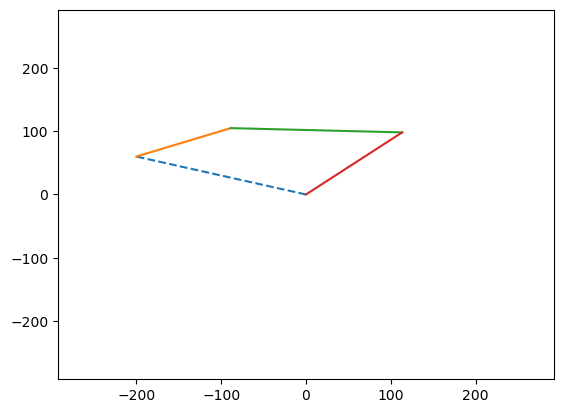

In [41]:
fig, ax = plt.subplots()

curr = complex(0,0)
links = np.zeros(4, object)

linknames = ['G', 'link1', 'link2', 'link3']

i = 0 # Selection from different solutions for accel problem
for n in range(4):
    l = linknames[n]
    prev = complex(curr)
    curr = curr + kin[l][i]
    if l == "G":
        linestyle = "--"
    else:
        linestyle = ""
    
    prev_plt = prev * np.exp(-1j * (ground_ang))
    curr_plt = curr * np.exp(-1j * (ground_ang))

    links[n] = ax.plot([np.real(prev_plt), np.real(curr_plt)],
             [np.imag(prev_plt), np.imag(curr_plt)],
             linestyle)[0]

ax.set_xlim(-1 * lengths['G']*1.4, lengths['G']*1.4)
ax.set_ylim(-1 * lengths['G']*1.4, lengths['G']*1.4)

_Note: above is horizontal basis, even though leg is vertical basis._

Text(0.5, 1.0, 'Angular Velocities')

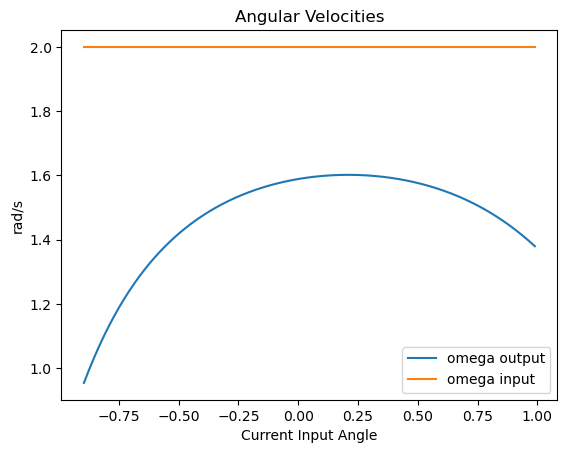

In [42]:
fig, ax = plt.subplots()
ax.plot(angs - np.pi/2, kin['omega3'], label = "omega output")
ax.plot(angs - np.pi/2,kin['omega1'], label = "omega input")
ax.legend()
ax.set_xlabel("Current Input Angle")
ax.set_ylabel("rad/s")
ax.set_title("Angular Velocities")

$\tau_1 * \omega_1 = \tau_3 * \omega_3$

$\frac{\tau_3}{\tau_1} = TR = \frac{ \omega_1 }{ \omega_3 }$

For evaluating torque ratio, and eventual control system mapping:

Text(0.5, 1.0, 'Effective Torque Function, Pitch Linkage')

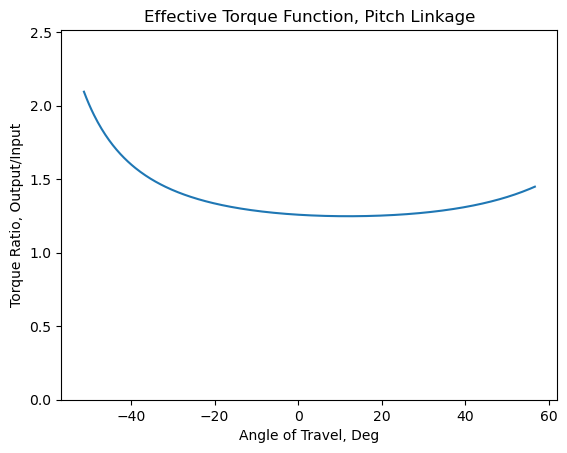

In [43]:
fig, ax = plt.subplots()
tr = np.zeros(len(kin['omega3']))
for i in range(len(tr)):
    if kin['omega1'][i] == 0 or kin['omega3'][i] == 0:
        tr[i] = 0
    else:
        tr[i] = kin['omega1'][i] / kin['omega3'][i]

ax.plot( (angs - np.pi/2) * 180/np.pi, tr)
ax.set_ylabel("Torque Ratio, Output/Input")
ax.set_xlabel("Angle of Travel, Deg")
ax.set_ylim((0, np.max(tr) * 1.2))
ax.set_title("Effective Torque Function, Pitch Linkage")

In [44]:
# Plotting w/ Anim
fig, ax = plt.subplots()

curr = complex(0,0)
links = np.zeros(4, object)

linknames = ['G', 'link1', 'link2', 'link3']

i = 0
for n in range(4):
    l = linknames[n]
    prev = complex(curr)
    curr = curr + kin[l][i]
    if l == "G":
        linestyle = "--"
    else:
        linestyle = ""
    
    prev_plt = prev * np.exp(-1j * (ground_ang + np.pi/2))
    curr_plt = curr * np.exp(-1j * (ground_ang + np.pi/2))

    links[n] = ax.plot([np.real(prev_plt), np.real(curr_plt)],
             [np.imag(prev_plt), np.imag(curr_plt)],
             linestyle)[0]

def update(frame):  
    curr = complex(0,0)

    linknames = ['G', 'link1', 'link2', 'link3']
  
    for n in range(4):
        l = linknames[n]
        prev = complex(curr)
        curr = curr + kin[l][frame]
        
        prev_plt = prev * np.exp(-1j * (ground_ang + np.pi/2))
        curr_plt = curr * np.exp(-1j * (ground_ang + np.pi/2))

        links[n].set_xdata([np.real(prev_plt), np.real(curr_plt)])
        links[n].set_ydata([np.imag(prev_plt), np.imag(curr_plt)])
    
    return links

ax.set_xlim(-1 * lengths['G']*1.4, lengths['G']*1.4)
ax.set_ylim(-1 * lengths['G']*1.4, lengths['G']*1.4)


ani = anim.FuncAnimation(fig = fig, func = update, frames = [i * 10 for i in range(int(resolution / 10))], interval = 60)
ani.save("4bar_pitch.gif", writer = "pillow")
plt.close()

In [45]:
HTML('<img src="./4bar_pitch.gif">')